Use the donuts with same intensity, but different degrees of vignetting, from 

In [2]:
import yaml
import os
import numpy as np
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
    CentroidFindType
)

from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)

from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom as cameraGeom
from lsst.afw.cameraGeom import FOCAL_PLANE, PIXELS, FIELD_ANGLE
from lsst.geom import Point2D

from astropy.visualization import ZScaleInterval

import centroid_functions as func 
import algoritm_store_functions as algo_func

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_17/phosimData/


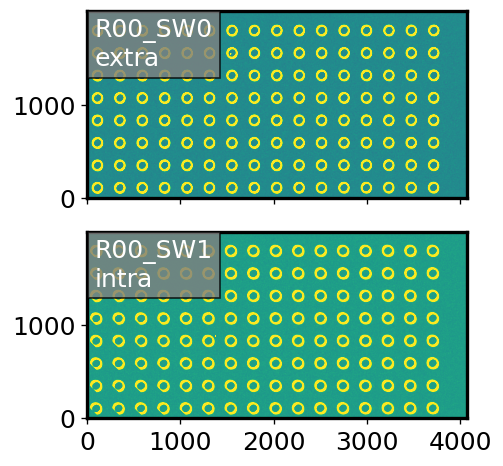

In [3]:
# Load the stamps
#path_to_project ='/sdf/group/rubin/ncsa-project/project/scichris/aos/'
#repo_name  = 'masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'
#repo_dir = os.path.join(path_to_project, repo_name)
mag = 17 
repo_dir = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/phosimData/'
print(repo_dir)
instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'
  
# choose R00 or R44
sensor = 'R00'
#print(f'Fitting {sensor}')
donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

extraImage = func.get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)

intraImage = func.get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW1",
                              collection=collection)
pixelScaleArcsec = extraImage.getWcs().getPixelScale().asArcseconds()


zscale = ZScaleInterval()

if sensor[1] == sensor[2]:
    ncols=1; nrows=2
else:
    ncols=2; nrows=1

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4, 4), sharex=True, sharey=True, dpi=120)

# intra is more vignetted
if sensor[1] == "4":
    ax = ax[::-1]

# plot the extrafocal chip
i=0
for exposure, label in zip([extraImage, intraImage], ['extra','intra']):
    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)
    ax[i].imshow(data, vmin=vmin,vmax=vmax,origin="lower")
    ax[i].text(0.02, 0.96, f"{ exposure.getInfo().getDetector().getName()}\n{label}", 
    transform=ax[i].transAxes, ha="left", va="top", c="w",fontsize=15,
             bbox=dict(facecolor='grey', alpha=0.8, edgecolor='black'))
    i=1


plt.tight_layout()
plt.show()



Stack before zernike estimation:


    - would need to provide uniform background
    - would need proper orientation...
    - perhaps after the "recenter" stage? 
    
    
Steps that use the `fieldX`, `fieldY` information :

* itr0: [compensable.makeMask()](https://github.com/lsst-ts/ts_wep/blob/ab8d9c7c55f5f654be3ccf91e78bf3ac5cd1a3c6/python/lsst/ts/wep/cwfs/Algorithm.py#L694) (done separately on I1 and I2) 

* itr0: [compensable.imageCoCenter()](https://github.com/lsst-ts/ts_wep/blob/ab8d9c7c55f5f654be3ccf91e78bf3ac5cd1a3c6/python/lsst/ts/wep/cwfs/CompensableImage.py#L273) (done separately on I1 and I2 to apply radial shift that depends on distance from the center of the focal plane

* itrN : [compensable.compensate()](https://github.com/lsst-ts/ts_wep/blob/ab8d9c7c55f5f654be3ccf91e78bf3ac5cd1a3c6/python/lsst/ts/wep/cwfs/Algorithm.py#L748) (done separately on I1 and I2, to forward each to the pupil plane) 

* itrN:  [algo._applyI1I2mask_pupil()](https://github.com/lsst-ts/ts_wep/blob/ab8d9c7c55f5f654be3ccf91e78bf3ac5cd1a3c6/python/lsst/ts/wep/cwfs/Algorithm.py#L760) (which, if `fieldX` , `fieldY` are different for two images,  multiplies both by the common pupil mask - the overlap between the two individual I1 and I2 pupil masks)

The problem is that if we eg. combined two images after the `imageCoCenter` stage, then which `fieldX`, `fieldY` information ought to be used for the subsequent stages? Would it need to be updated as a median of the two ? 



Another issue: do that uniformly for eg. two I1 and two I2? I guess so, because otherwise we'd have a different effective exposure time  on "stacked" I1 vs "unstacked" I2.

Stacking outline:
    
    * Use donuts cut out and already stored in butler 
    * Stack images in the image plane, make a new donut stamp which would have field coordinates equal to the average of the field coordinates of the input donuts
    * Run algorithm , skipping the cocenter stage entirely 
    
    

Pseudocode: 
    
    * update before itrN would be easier  - if updating after migration to the pupil plane, which set of Zks were to be used during the calculation of Jacobian for compensation?
    * also, we want to keep the copy of the initial image (`updateImgInit()`), which is done only once (at the end of itr0). Otherwise I have no idea which image would be to be kept as the initial image
    * update fieldX, fieldY, content of compensable image 

In [4]:
# Set the number of donuts we want to stack 
#(at the moment in random order, i.e. without considering their degree of vignetting....)
N=100

In [5]:
def find_hot_pixels(donutStamps, threshold=3):
    
    hot_dic = {'i':[], 'vmax':[], 'gmax':[]}
    for i in range(len(donutStamps)):
        stamp = donutStamps[i]
        data = stamp.stamp_im.getImage().getArray()
        # find global min/max 
        gmin, gmax = np.min(data), np.max(data)

        # find zscale min, max
        vmin, vmax = zscale.get_limits(data)

        if gmax > threshold*vmax:
            print(i, vmax, gmax, 'potential hot pixel ')
            hot_dic['i'].append(i)
            hot_dic['vmax'].append(vmax)
            hot_dic['gmax'].append(gmax)
    if len(hot_dic['i'])==0:
        print(f'no hot pixels found where global max > {threshold} zscale vmax ')
        
    return hot_dic

In [6]:
hotExtra = find_hot_pixels(donutStampsExtra)

27 87.09021 34446.664 potential hot pixel 


In [7]:
hotIntra = find_hot_pixels(donutStampsIntra)

82 70.988754 34517.133 potential hot pixel 
97 73.98737 34498.14 potential hot pixel 


Somehow need to ignore these indices in the extra / intra donuts to consider 

In [16]:
extraIndices = np.arange(len(donutStampsExtra))
intraIndices = np.arange(len(donutStampsIntra))

#remove elements whose value is equal to the hot pixels... 
availableExtraIndices = np.setdiff1d(extraIndices,hotExtra['i'])
availableIntraIndices = np.setdiff1d(intraIndices,hotIntra['i'])


# since the default is to stack intra-i with extra-i, 
# and not some other donut, 
# ensure that both intra and extra donuts are removed if 
# one of them has a hot pixel that would contribute
# to bad wavefront measurement
availableIndices = np.intersect1d(availableExtraIndices, availableIntraIndices)

#choose N indices at random, do that M times
N = 10
M = 10
indices = {}
for i in range(M):
    chosenIndices = np.random.choice(availableIndices,size=N, replace=False)
    indices[i] = chosenIndices

In [19]:
np.save( 'random_indices_10.npy', indices)

In [64]:
import importlib as imp
imp.reload(algo_func)

# get the pixel scale from exposure to convert from pixels to arcsec to degrees
pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()
configDir = getConfigDir()
#instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

# inside wfEsti = WfEstimator(instDir, algoDir)
instName='lsst'
opticalModel = 'offAxis'
sizeInPix = 160  # aka donutStamps
solver = 'exp' # by default
debugLevel = 0 # 1 to 3
centroidFindType = CentroidFindType.RandomWalk
camType = getCamType(instName)
#defocalDisInMm = getDefocalDisInMm(instName)

# select the only donut pair in that corner
storage = {}
for i in range(100,106): # take intra_0,extra_0 and intra_1,extra_1 
    j = i 
    
    # skip if already calculated 
    coCenterText = 'noCocenter'
    fname = f'store_wfsGrid_{mag}_extra-{i}_intra-{j}_{coCenterText}.npy'
    fpath = os.path.join('DM-36218',fname)
    if os.path.exists(fpath):
        print(f'{fpath} already exists, skipping')
    
    else:
        donutExtra = donutStampsExtra[i]
        donutIntra = donutStampsIntra[j]

        # this is part of the init
        inst = Instrument()
        algo = Algorithm(algoDir)

        # inside estimateZernikes()

        # inside wfEsti.config
    #     inst.config(camType, sizeInPix, 
    #                 announcedDefocalDisInMm = defocalDisInMm)
        inst.configFromFile(sizeInPix, camType)

        # choose the solver for the algorithm
        algo.config(solver, inst, debugLevel=debugLevel)

        imgIntra = CompensableImage(centroidFindType=centroidFindType)
        imgExtra = CompensableImage(centroidFindType=centroidFindType)

        # Inside EstimateZernikesBase
        # Transpose field XY because CompensableImages below are transposed
        # so this gets the correct mask orientation in Algorithm.py
        fieldXYExtra = donutExtra.calcFieldXY()[::-1]
        fieldXYIntra = donutIntra.calcFieldXY()[::-1]

        camera = donutExtra.getCamera() # same camera for both donuts
        detectorExtra = camera.get(donutExtra.detector_name)
        detectorIntra = camera.get(donutIntra.detector_name)

        # Rotate any sensors that are not lined up with the focal plane.
        # Mostly just for the corner wavefront sensors. The negative sign
        # creates the correct rotation based upon closed loop tests
        # with R04 and R40 corner sensors.
        eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
        eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

        # now inside  `wfEsti.setImg` method,
        # which inherits from `CompensableImage`
        imgExtra.setImg(fieldXYExtra,
                        DefocalType.Extra,
                        image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

        imgIntra.setImg(fieldXYIntra,
                        DefocalType.Intra,
                        image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)


        # run the algorithm with unstacked images 
        algo, store = algo_func.runIt_store(algo, imgIntra, imgExtra, model=opticalModel, 
                                  tol=1e-3,doCoCenter=False)

        print(f'Saved as {fpath}')

        np.save(fpath, store, )

Saved as DM-36218/store_wfsGrid_17_extra-100_intra-100_noCocenter.npy
Saved as DM-36218/store_wfsGrid_17_extra-101_intra-101_noCocenter.npy
Saved as DM-36218/store_wfsGrid_17_extra-102_intra-102_noCocenter.npy
Saved as DM-36218/store_wfsGrid_17_extra-103_intra-103_noCocenter.npy


IndexError: list index out of range

Before stacking: show that the image level is similar for all donuts in the postISR intra-m and extra-images:

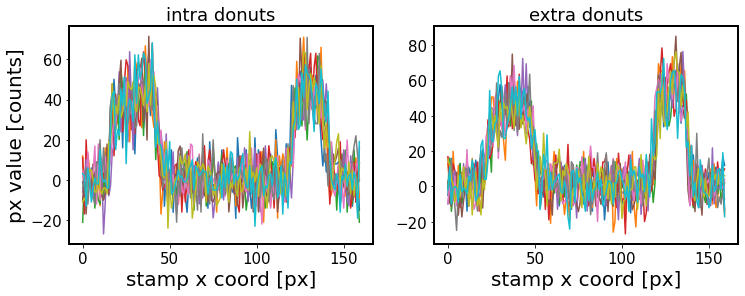

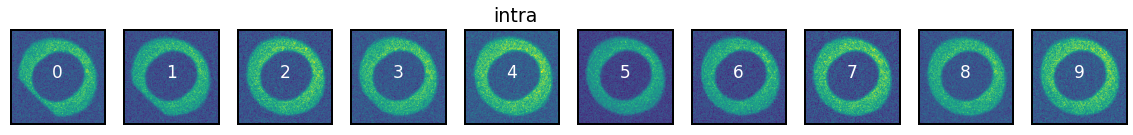

In [20]:
def plot_stamps(donutStamps, title='intra-focal',ncols=None,
               N=10, panel_width = 4, indices=None):
    #N = len(donutStamps)
    if indices is None:
        # take first N donuts
        indices = np.arange(N)
        
    else:  # infer the number of donuts to plot from the number of indices provided 
        N = len(indices)

    if ncols is None:
        nrows=5
        ncols=(N // nrows)
    else:
        nrows=(N//ncols)
        
    if N % nrows>0:
        ncols+=1
    fig,axs = plt.subplots(nrows,ncols, figsize=(ncols*panel_width,
                                                 nrows*panel_width))
    ax = np.ravel(axs)
    i = 0 
    
    for j in indices:
        stamp = donutStamps[j]
        data =  stamp.stamp_im.getImage().getArray()
        vmin, vmax = zscale.get_limits(data)
        ax[i].imshow(data, vmin=vmin,vmax=vmax, origin='lower')
        ax[i].text(70,80, f'{i}', fontsize=17, c='white')
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        i += 1 
    M = nrows*ncols
    for i in range(N,M):
        ax[i].axis('off')
    fig.text(0.46, 0.89, title, fontsize=19)
    
    
#Nextra=N
#Nintra=N

fig,ax = plt.subplots(1,2,figsize=(12,4))
for j in indices[0]:
#for j in range(Nintra):
    ax[0].plot(donutStampsIntra[j].stamp_im.getImage().getArray()[100,:])
    ax[1].plot(donutStampsExtra[j].stamp_im.getImage().getArray()[100,:])
#for j in range(Nextra):
    

ax[0].set_title('intra donuts')
ax[1].set_title('extra donuts')
ax[0].set_ylabel('px value [counts]')
ax[1].set_xlabel('stamp x coord [px]')
ax[0].set_xlabel('stamp x coord [px]')

plot_stamps(donutStampsIntra, title='intra', ncols=10, N=N, panel_width=2,
           indices=indices[0])
#plot_stamps(donutStampsExtra, title='extra', ncols=5)

### Aside : check the image levels for some donuts..;. 

-30.91558 -23.94547 88.572014 75.627525
-34.9573 -26.969217 85.86241 71.98829
-31.963865 -26.966166 34517.133 70.988754
-33.962944 -28.965246 86.98139 78.98507
-35.78162 -21.849941 93.58398 67.71086


Text(0.46, 0.89, 'intra')

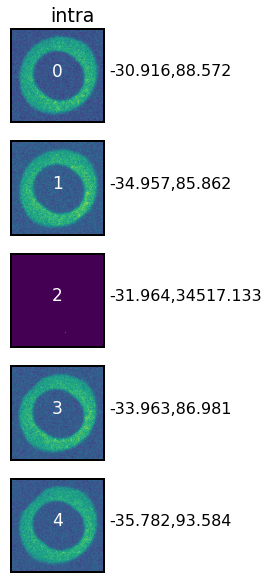

In [109]:
title='intra'
ncols=1
Nmax=85
Nmin=80
N=Nmax-Nmin
panel_width=2   
donutStamps=donutStampsIntra#N = len(donutStamps)
if ncols is None:
    nrows=5
    ncols=(N // nrows)
else:
    nrows=(N // ncols)

if N % nrows>0:
    ncols+=1
fig,axs = plt.subplots(nrows,ncols, figsize=(ncols*panel_width,
                                             nrows*panel_width))
ax = np.ravel(axs)
i = 0 
for stamp in donutStamps[Nmin:Nmax]:
    data =  stamp.stamp_im.getImage().getArray()
    # by default imshow uses the full data range for vmin, vmax 
    vmin, vmax = zscale.get_limits(data)
    
    print(np.min(data), vmin, np.max(data), vmax)
    
    #ax[i].imshow(data, vmin=vmin,vmax=vmax, origin='lower')
    ax[i].imshow(data)
    ax[i].text(70,80, f'{i}', fontsize=17, c='white')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    imgs = ax[i].get_images()
    if len(imgs) > 0:
        vmin, vmax = imgs[0].get_clim()
        #print(vmin, vmax)
        ax[i].text(1.05,0.5, f'{np.round(vmin,3)},{np.round(vmax,3)}',fontsize=16, transform=ax[i].transAxes)
    
    i += 1 
M = nrows*ncols
for i in range(N,M):
    ax[i].axis('off')
fig.text(0.46, 0.89, title, fontsize=19)


## Fit stacked donuts:
    
    * take a mean of all x-coordinates of all donuts to be stacked 
    * take a mean of all y-coordinates --- || ---
    * add up the image value for all stacked donuts 

In [53]:
np.shape(donutStampsExtra[0].stamp_im.image.array)[0]

160

In [21]:
def stack_donuts(donutStampsIntra, donutStampsExtra, N=2, indices = None,
            ):
    '''
    donutStampsIntra: a collection of intra-focal donut stamps
    donutStampsExtra: a collection of extra-focal donut stamps
    N : up to how many donuts to stack together from the list? 
    '''

    # first , ensure we have that many donuts to stack ... 
    # assuming we stack the same number of extra-focal donuts and intra-focal donuts 
    # we could also stack just donuts on one side of focus,
    # but then we would have uneven depth (much deeper intra-image vs extra-image... )

    stacked_dic = {}

    Nextra = len(donutStampsExtra)
    Nintra = len(donutStampsIntra)
    
    if indices is None:
        Nmax = min(Nextra,Nintra)
        if N>Nmax: 
            N=Nmax
            print(f'Only available {Nmax} donuts to stack, setting N={N}')
        indices = np.arange(N)
        
    else:
        N = len(indices)
        
    stacked_dic['N']=N
    stacked_dic['indices'] = indices
    
    # create updated donut stamps consisting of the stacked images

    # initialize empty arrays of the correct dimension
    shape = np.shape(donutStampsExtra[0].stamp_im.image.array)
    donutIntraStackedArray = np.zeros(shape)
    donutExtraStackedArray = np.zeros(shape)

    # add donut image arrays
    for i in indices:
        print(f'stacking {i}')
        donutIntraStackedArray += donutStampsIntra[i].stamp_im.getImage().getArray()
        donutExtraStackedArray += donutStampsExtra[i].stamp_im.getImage().getArray()

    stacked_dic['donutIntraStackedArray'] = donutIntraStackedArray
    stacked_dic['donutExtraStackedArray'] = donutExtraStackedArray
    
    # find the midpoint fieldXY coordinates
    # average in the same way x and y coordinates 
    # for the intra and extra donut alike
    # treat them as already transposed

    stampMeanXY = []
    for stamps in [donutStampsIntra, donutStampsExtra]:
        xs = []
        ys = []
        for i in indices:
            XY = stamps[i].calcFieldXY()[::-1]
            xs.append(XY[0])
            ys.append(XY[1])
            #print(XY)
        stampMeanXY.append((np.mean(xs), np.mean(ys)))
        # print('xs:' ,xs)
        # print('<xs>', np.mean(xs))
        # print('ys:', ys)
        # print('<ys', np.mean(ys))
    donutIntraMeanXY, donutExtraMeanXY = stampMeanXY
    stacked_dic['donutIntraMeanFieldXY'] = donutIntraMeanXY
    stacked_dic['donutExtraMeanFieldXY'] = donutExtraMeanXY
    
    return stacked_dic

In [22]:
stacked_dic = stack_donuts(donutStampsIntra, donutStampsExtra, indices=indices[0])

stacking 64
stacking 76
stacking 51
stacking 83
stacking 39
stacking 5
stacking 77
stacking 37
stacking 79
stacking 56


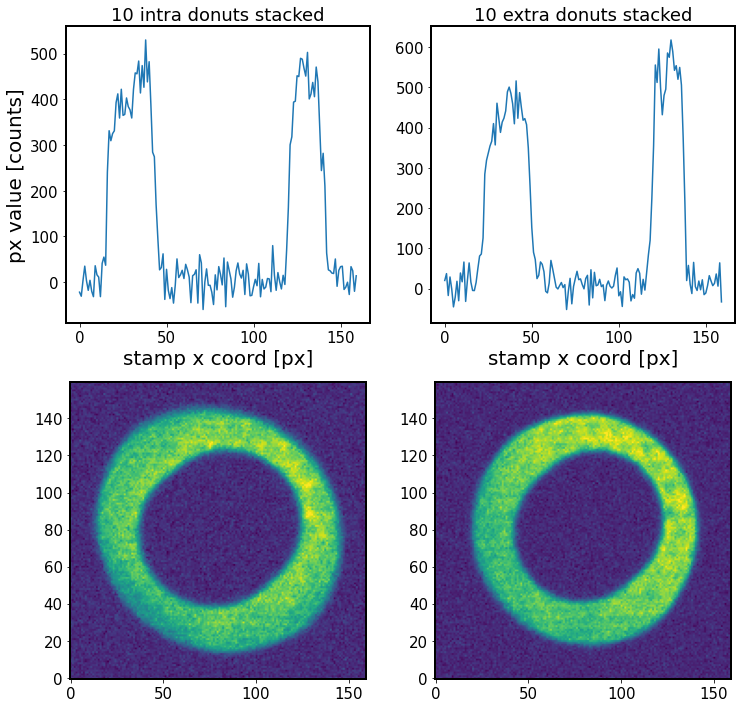

In [23]:
fig,ax = plt.subplots(2,2,figsize=(12,12))

dataIntra = stacked_dic['donutIntraStackedArray']
dataExtra = stacked_dic['donutExtraStackedArray'] 
ax[0,0].plot(dataIntra[100,:])
ax[0,1].plot(dataExtra[100,:])
N = len(indices)
ax[0,0].set_title(f'{N} intra donuts stacked')
ax[0,1].set_title(f'{N} extra donuts stacked')
ax[0,0].set_ylabel('px value [counts]')
ax[0,1].set_xlabel('stamp x coord [px]')
ax[0,0].set_xlabel('stamp x coord [px]')

vmin, vmax = zscale.get_limits(dataIntra)
ax[1,0].imshow(dataIntra, vmin=vmin,vmax=vmax, origin='lower') 

vmin, vmax = zscale.get_limits(dataExtra)
ax[1,1].imshow(dataExtra, vmin=vmin,vmax=vmax, origin='lower') 



This illustrates one problem of stacking - if there is a hot pixel in one donut, it gets added to all the other ones. We would need a more robuts hot pixel detection to deal with that at the postage stamp stage, and remove these stamps from stacking 

Run the wavefront estimation with stacking the zernikes:

In [24]:
# run again, but now stacking the images before passing to the algorithm...
# get the pixel scale from exposure to convert from pixels to arcsec to degrees
pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()
configDir = getConfigDir()
#instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

# inside wfEsti = WfEstimator(instDir, algoDir)
instName='lsst'
opticalModel = 'offAxis'
sizeInPix = 160  # aka donutStamps
solver = 'exp' # by default
debugLevel = 0 # 1 to 3
centroidFindType = CentroidFindType.RandomWalk
camType = getCamType(instName)

# grab camera and detector from any donut .... 
donutExtra=  donutStampsExtra[0]
donutIntra= donutStampsIntra[0]
camera = donutExtra.getCamera() # same camera for both donuts
detectorExtra = camera.get(donutExtra.detector_name)
detectorIntra = camera.get(donutIntra.detector_name)

        

# now stack the images, combining the fieldXY
# this step is already done above
for M in indices.keys():
    N = len(indices[M])
    stacked_dic = stack_donuts(donutStampsIntra, donutStampsExtra, indices=indices[M])
    
    # need to save the stacked donuts, together with indices that were used to do the stacking ...
    np.save(f'stacked_{N}-donuts_set_{M}.npy', stacked_dic)
    # this is part of the init
    inst = Instrument()
    algo = Algorithm(algoDir)

    # inside estimateZernikes()
    camType = getCamType(instName)
    defocalDisInMm = getDefocalDisInMm(instName)

    # inside wfEsti.config
    inst.configFromFile(sizeInPix, camType)

    # choose the solver for the algorithm
    algo.config(solver, inst, debugLevel=debugLevel)

    centroidFindType = CentroidFindType.RandomWalk

    # initialize compensable image 
    imgIntra = CompensableImage(centroidFindType=centroidFindType)
    imgExtra = CompensableImage(centroidFindType=centroidFindType)

    # Inside EstimateZernikesBase
    # transpose field XY because CompensableImages below are transposed
    # so this gets the correct mask orientation in Algorithm.py
    #fieldXYExtra = donutExtra.calcFieldXY()[::-1]
    #fieldXYIntra = donutIntra.calcFieldXY()[::-1]
    fieldXYExtra = stacked_dic['donutExtraMeanFieldXY']
    fieldXYIntra = stacked_dic['donutIntraMeanFieldXY']

    # the same as for single individual donuts fitted above 
    #camera = donutExtra.getCamera() # same camera for both donuts
    #detectorExtra = camera.get(donutExtra.detector_name)
    #detectorIntra = camera.get(donutIntra.detector_name)

    # Rotate any sensors that are not lined up with the focal plane.
    # Mostly just for the corner wavefront sensors. The negative sign
    # creates the correct rotation based upon closed loop tests
    # with R04 and R40 corner sensors.
    eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
    eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

    # now inside  `wfEsti.setImg` method,
    # which inherits from `CompensableImage`
    imgExtra.setImg(fieldXYExtra,
                    DefocalType.Extra,
                    image=rotate(stacked_dic['donutExtraStackedArray'] , eulerZExtra).T)

    imgIntra.setImg(fieldXYIntra,
                    DefocalType.Intra,
                    image=rotate(stacked_dic['donutIntraStackedArray'] , eulerZIntra).T)


    # run the algorithm with unstacked images 
    algo, store = algo_func.runIt_store(algo, imgIntra, imgExtra, model=opticalModel, 
                              tol=1e-3,doCoCenter=False)



    coCenterText = 'noCocenter'
    #fname = f'store_extra-0-{N}_intra-0-{N}_stacked_{coCenterText}.npy'

    #fname = f'store_wfsGrid_{mag}_extra-0-{N}_intra-0-{N}_stacked_{coCenterText}.npy'
    fname = f'store_wfsGrid_{mag}_extra_intra_choose_{N}_set_{M}_{coCenterText}.npy'
    fpath = os.path.join('DM-36218',fname)
    print(fpath)
    np.save(fpath, store, )

stacking 64
stacking 76
stacking 51
stacking 83
stacking 39
stacking 5
stacking 77
stacking 37
stacking 79
stacking 56
DM-36218/store_wfsGrid_17_extra_intra_choose_10_set_0_noCocenter.npy
stacking 28
stacking 59
stacking 6
stacking 34
stacking 42
stacking 3
stacking 40
stacking 5
stacking 55
stacking 74
DM-36218/store_wfsGrid_17_extra_intra_choose_10_set_1_noCocenter.npy
stacking 40
stacking 28
stacking 67
stacking 2
stacking 8
stacking 13
stacking 93
stacking 95
stacking 26
stacking 14
DM-36218/store_wfsGrid_17_extra_intra_choose_10_set_2_noCocenter.npy
stacking 90
stacking 81
stacking 19
stacking 11
stacking 52
stacking 73
stacking 42
stacking 20
stacking 54
stacking 72
DM-36218/store_wfsGrid_17_extra_intra_choose_10_set_3_noCocenter.npy
stacking 72
stacking 31
stacking 26
stacking 8
stacking 20
stacking 94
stacking 18
stacking 42
stacking 83
stacking 57
DM-36218/store_wfsGrid_17_extra_intra_choose_10_set_4_noCocenter.npy
stacking 2
stacking 88
stacking 9
stacking 58
stacking 103
sta

Compare the Zernikes - are they any better? Use the individual results from exactly the same pairs that got stacked:

In [25]:
coCenterText = 'noCocenter'
N=10
fname = f'store_wfsGrid_{mag}_extra_intra_choose_{N}_set_{M}_{coCenterText}.npy'
fpath= os.path.join('DM-36218',fname)
store = np.load(fpath, allow_pickle=True).item()


In [59]:
import analysisTools as at
import importlib as imp
imp.reload(at)

<module 'analysisTools' from '/sdf/data/rubin/u/scichris/WORK/AOS/analysisTools.py'>

ValueError: x and y must have same first dimension, but have shapes (19,) and (4, 19)

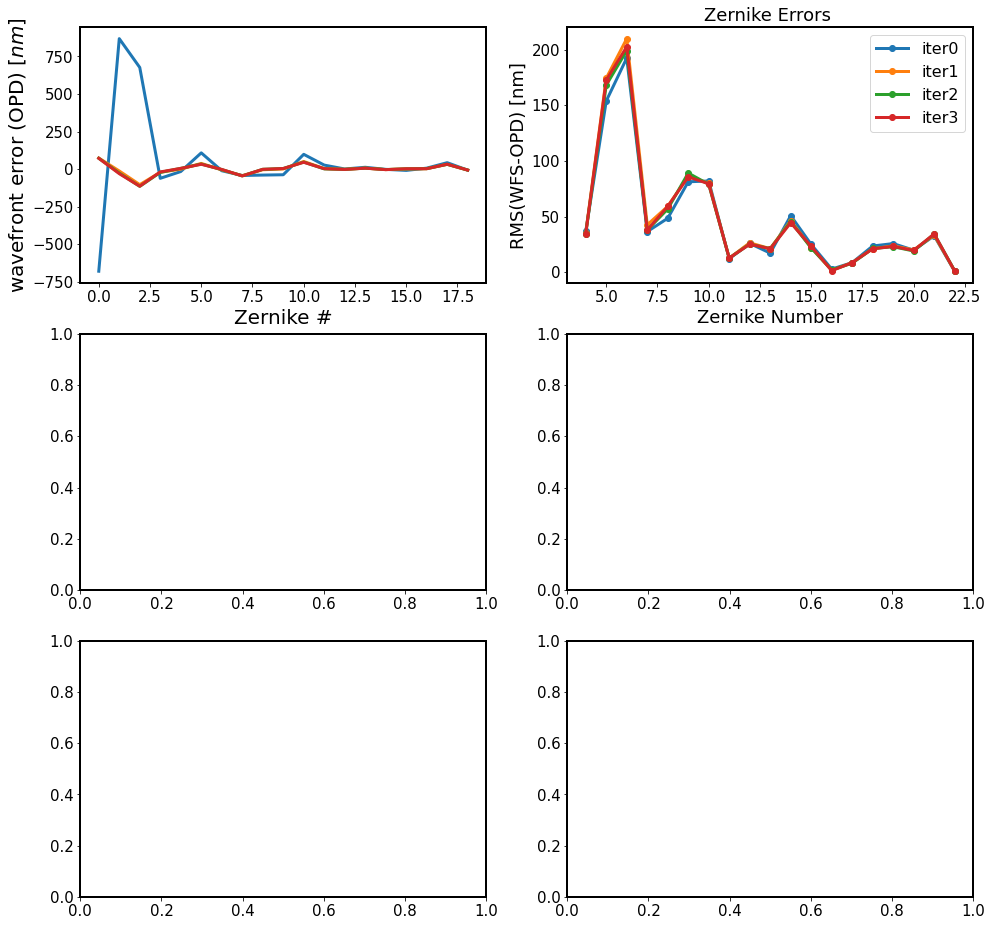

In [60]:

mag=17
data_dir = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/'
at.plotIterationSummary(data_dir, iterNum=4, num_ccds=4)

In [48]:
iterN = 3
opdZkFilePath = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/iter{iterN}/img/opd.zer'
opdData = np.loadtxt(opdZkFilePath)

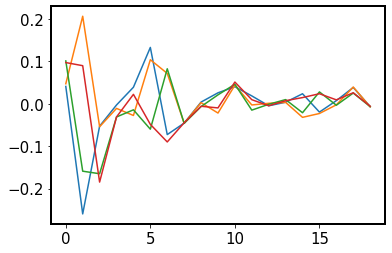

In [49]:
for i in range(len(opdData)):
    plt.plot(opdData[i])

In [51]:
np.mean(opdData, axis=0)

array([ 0.07166637, -0.03049231, -0.11397188, -0.01885732,  0.00496839,
        0.03217287, -0.00200335, -0.04550722, -0.001351  ,  0.00393371,
        0.0454169 ,  0.00272137, -0.00224329,  0.00612896, -0.00360967,
        0.0024034 ,  0.00278039,  0.03242333, -0.00643916])

Text(0, 0.5, 'Zernike Coefficient [nm]')

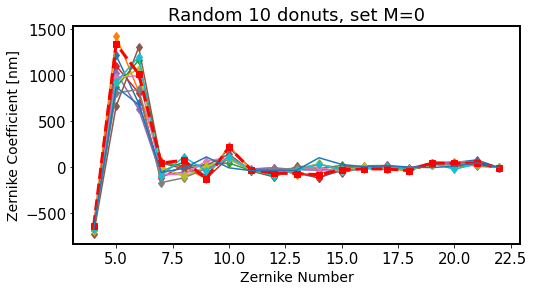

In [56]:
M=0

# get the OPD data
iterN=0
opdZkFilePath = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/iter{iterN}/img/opd.zer'
opdData = np.loadtxt(opdZkFilePath)

# get wavefront estimates from individual pairs 
# i.e. intra0 with extra0, etc... 
indices = np.load('random_indices_10.npy',allow_pickle=True).item()
zks=[]
for i in indices[M]:
    j=i
    fname = f'store_wfsGrid_{mag}_extra-{i}_intra-{j}_{coCenterText}.npy'
    fpath= os.path.join('DM-36218',fname)
    store = np.load(fpath, allow_pickle=True).item()
    zk = store[14]['zer4UpNm']
    zks.append(zk)

fname = f'store_wfsGrid_{mag}_extra_intra_choose_{N}_set_{M}_{coCenterText}.npy'
fpath= os.path.join('DM-36218',fname)
store = np.load(fpath, allow_pickle=True).item()

# fname = f'DM-35922_store_extra-{i}_intra-{j}_noCocenter.npy'
# store1 = np.load(fname, allow_pickle=True).item()
zkc = store[14]['zer4UpNm']

# simulated data
fig,ax = plt.subplots(1,1,figsize=(8,4))

# plot the individual donuts 
for i in range(N):
    
    #fname = f'store_extra-{i}_intra-{j}_{coCenterText}.npy'
   
    plt.plot(np.arange(4, 23),zks[i], '-d', label=f'{i}',
                )
    
# plot the averaged donuts
#N=2
#fname = f'store_extra-0-{N}_intra-0-{N}_stacked_{coCenterText}.npy'

plt.plot(np.arange(4, 23),zkc, '--s', lw=3, c='r',label=f'stack {N} donuts',
            )


# plot the mean  data for that iteration
# need to convert the OPD data from microns 
# to nanometers ... 
plt.plot(np.arange(4, 23), 1000*np.mean(opdData, axis=0), label=f'mean OPD')

plt.title(f'Random {N} donuts, set M={M}')
plt.xlabel('Zernike Number', size=14)
plt.ylabel('Zernike Coefficient [nm]', 
        size=14)
#plt.legend(bbox_to_anchor=[1, 1.05], ncol=2)




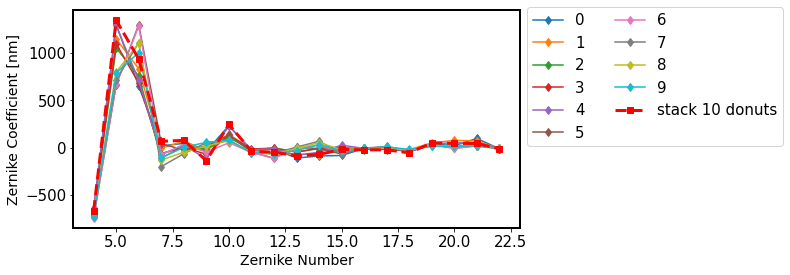

In [66]:

zks=[]
for i in range(N):
    j=i
    fname = f'store_wfsGrid_{mag}_extra-{i}_intra-{j}_{coCenterText}.npy'
    fpath= os.path.join('DM-36218',fname)
    store = np.load(fpath, allow_pickle=True).item()
    zk = store[14]['zer4UpNm']
    zks.append(zk)

fname = f'store_wfsGrid_{mag}_extra-0-{N}_intra-0-{N}_stacked_{coCenterText}.npy'
fpath= os.path.join('DM-36218',fname)
store = np.load(fpath, allow_pickle=True).item()

# fname = f'DM-35922_store_extra-{i}_intra-{j}_noCocenter.npy'
# store1 = np.load(fname, allow_pickle=True).item()
zkc = store[14]['zer4UpNm']

# simulated data
fig,ax = plt.subplots(1,1,figsize=(8,4))

# plot the individual donuts 
for i in range(N):
    
    #fname = f'store_extra-{i}_intra-{j}_{coCenterText}.npy'
   
    plt.plot(np.arange(4, 23),zks[i], '-d', label=f'{i}',
                )
    
# plot the averaged donuts
#N=2
#fname = f'store_extra-0-{N}_intra-0-{N}_stacked_{coCenterText}.npy'

plt.plot(np.arange(4, 23),zkc, '--s', lw=3, c='r',label=f'stack {N} donuts',
            )

plt.xlabel('Zernike Number', size=14)
plt.ylabel('Zernike Coefficient [nm]', 
        size=14)
plt.legend(bbox_to_anchor=[1, 1.05], ncol=2)



What's that green weird result when stacking N=100 donuts ? 

In [71]:
i=0
for zk in zks:
    if zk[1] < 200:
        print(i, zk)
    i += 1 

82 [-718.23000426  120.66585362 -674.27380537   99.14634188  644.79011106
 -513.9233537  -532.94772003   55.93775534  313.66100202  167.06617992
 -352.40969808 -617.40962978   -8.19228903   -4.85375677  206.00045625
  256.53595143 -218.60187506 -374.16315905  -16.44254093]


In [80]:
donutStampsIntra[82].stamp_im.getImage().getArray()

array([[ 4.0195732e+00,  1.9012672e+01, -1.9776665e+00, ...,
         1.1016354e+01,  2.0204935e+00, -9.7812647e-01],
       [-9.9739866e+00, -5.9758263e+00,  1.3015433e+01, ...,
         1.7013594e+01,  5.0191135e+00, -1.9776665e+00],
       [ 5.0191135e+00, -4.9762864e+00,  3.4005772e+01, ...,
        -6.9753661e+00,  3.0200334e+00,  6.0186534e+00],
       ...,
       [ 1.1016354e+01,  1.0016813e+01, -4.9762864e+00, ...,
        -9.7812647e-01,  3.0200334e+00, -6.9753661e+00],
       [ 1.0209534e+00, -1.8969847e+01, -3.9767463e+00, ...,
         1.1016354e+01, -3.9767463e+00,  2.1413485e-02],
       [ 4.0195732e+00,  1.2015893e+01, -2.9772065e+00, ...,
        -1.0973526e+01,  1.0209534e+00, -2.9772065e+00]], dtype=float32)

    We see that there is a hot pixel in the intra-focal stamp, which completely messes up the wavefront estimation. If we don't use the `zscale.get_limits` to change `vmin` , `vmax`, we don't even see the intra-focal donut because the image `vmax` gets dominated by the hot pixel... 

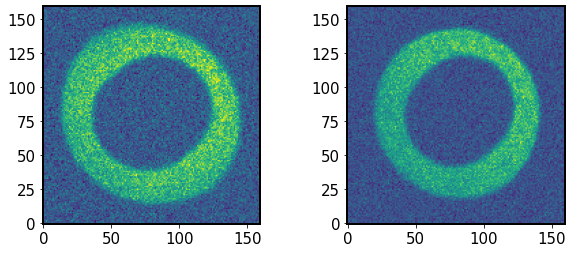

In [87]:
j=82
fig,ax = plt.subplots(1,2,figsize=(10,4))
data = donutStampsIntra[j].stamp_im.image.array
vmin, vmax = zscale.get_limits(data)
ax[0].imshow(data,vmin=vmin, vmax=vmax, origin='lower')

ax[1].imshow(donutStampsIntra[j].stamp_im.image.array,origin='lower')
ax[1].imshow(donutStampsExtra[j].stamp_im.image.array,origin='lower')




Compare mean of zernikes vs zernikes of stacked images:

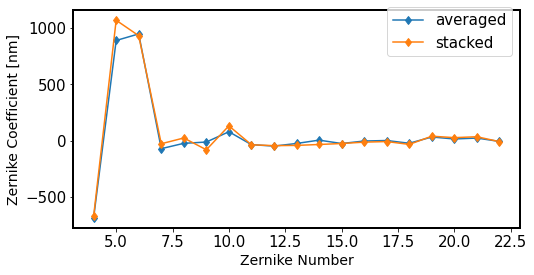

In [88]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

plt.plot(np.arange(4, 23), np.mean(zks,  axis=0), '-d', label='averaged')
plt.plot(np.arange(4, 23),zkc, '-d', label='stacked')
plt.xlabel('Zernike Number', size=14)
plt.ylabel('Zernike Coefficient [nm]', 
        size=14)
plt.legend(bbox_to_anchor=[1, 1.05])


Now the stacked image  does not suffer as much from the hot pixel as the mean which is susceptible to outliers.  It would be better to combine zernikes with median, or a weight dependent on the quality of the input donut postage stamp. 

In [18]:
I.getImg()

array([[322.59772, 281.6588 , 292.64243, ..., 322.59772, 284.65433,
        298.63348],
       [314.60965, 319.60217, 309.6171 , ..., 299.632  , 350.556  ,
        309.6171 ],
       [330.5858 , 267.67966, 295.63794, ..., 328.58878, 324.59473,
        316.60666],
       ...,
       [324.59473, 301.629  , 310.6156 , ..., 306.62155, 300.6305 ,
        324.59473],
       [338.57388, 299.632  , 336.57684, ..., 306.62155, 303.62604,
        358.54407],
       [272.6722 , 287.64987, 330.5858 , ..., 327.59027, 322.59772,
        268.67816]], dtype=float32)